In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import CoxPHFitter


# <span style="color:#A0522D">1. Problematique  :</span> 

### 1.1 Introduction

Dans les marchés financiers modernes, des centaines de facteurs quantitatifs sont utilisés pour expliquer les rendements des actifs et pour construire des stratégies d’investissement. Ces facteurs — tels que value, momentum ou quality — génèrent des primes de risque systématiques exploitées par les investisseurs institutionnels et les fonds quantitatifs. Cependant, ces primes ne sont pas permanentes : avec le temps, la performance d’un facteur tend à s’éroder, sa significativité statistique diminue et son avantage compétitif disparaît progressivement. Ce phénomène est souvent désigné comme la décroissance ou la défaillance d’un facteur.

L’apparition de nouveaux facteurs, la saturation des marchés, l’évolution des régimes économiques ou encore la concurrence algorithmique peuvent influencer la durée de validité de ces signaux. Pour les gestionnaires de portefeuille, cette incertitude représente un défi majeur : continuer à exploiter un facteur obsolète peut entraîner des pertes importantes, tandis qu’abandonner trop tôt un facteur robuste peut réduire la performance globale. Il devient donc crucial de quantifier la durée de vie des facteurs et d’identifier les conditions dans lesquelles ils cessent d’être efficaces.

Afin d’analyser cette problématique, nous proposons d’appliquer des méthodes d’analyse de survie. Cette approche statistique, habituellement utilisée dans les domaines biomédical ou industriel, permet de modéliser le temps jusqu’à la survenue d’un événement — ici, l’“échec” d’un facteur financier. L’analyse de survie permet également de prendre en compte le censorship, c’est-à-dire les facteurs toujours actifs au moment de l’analyse, ce que les méthodes classiques de performance ne gèrent pas correctement.

Ce travail vise donc à :

modéliser la durée de vie de différents facteurs quantitatifs ;

comparer leur probabilité de défaillance ;

étudier l’influence de variables de marché (volatilité, taux d’intérêt, régimes économiques) sur le risque d’extinction.

Les résultats obtenus doivent aider les investisseurs institutionnels à optimiser la rotation factorielle, à réduire les coûts d’exposition et à améliorer la résilience de leurs portefeuilles face à la dégradation progressive des signaux quantitatifs.

### 1.2 description des données

- Le jeu de données utilisé dans ce projet provient de la base Open Source Asset Pricing (OSAP), développée par Bryzgalova, Linnainmaa et Lustig (Université de Chicago, Stanford et UCLA).
Cette base de données open-source a pour objectif de reproduire et de centraliser les principaux facteurs de rendement présentés dans la littérature académique en finance empirique entre 1962 et 2023.


- Plus précisément, nous utilisons le fichier « Monthly Long-Short Returns of 212 Predictors », qui regroupe les rendements mensuels des portefeuilles long-short associés à plus de 200 facteurs (ou « prédicteurs »). Chaque colonne représente un facteur différent, construit selon les définitions des articles de recherche originaux (par exemple Value, Momentum, Investment, Profitability, Liquidity, etc.), tandis que chaque ligne correspond à un mois calendaire.


- Les rendements sont exprimés sous forme de taux mensuels ajustés du risque, calculés sur des portefeuilles neutres au marché. Ces données sont largement utilisées dans les études de validation empirique de modèles d’évaluation d’actifs et de stratégies factorielles (factor investing).

- Pour assurer la qualité statistique de l’échantillon, nous avons restreint notre période d’analyse à 1970–2024, période durant laquelle la majorité des facteurs disposent d’un historique complet. Les données sont déjà harmonisées et nettoyées par les auteurs de la base, ce qui garantit leur fiabilité et permet de se concentrer sur l’analyse méthodologique plutôt que sur la reconstruction des variables.

- parmi les plus de 200 facteurs disponibles dans la base Open Source Asset Pricing, nous avons choisi d’en retenir 15, représentant les dimensions les plus fondamentales de la littérature en finance empirique.
Cette sélection vise à réduire la complexité du jeu de données tout en conservant la diversité économique des sources de rendement.

### 1.3 description des données


 Nettoyage complet： (648, 15)
Nombre de facteurs avec des valeurs manquantes: 0
 Visualisez un facteur：


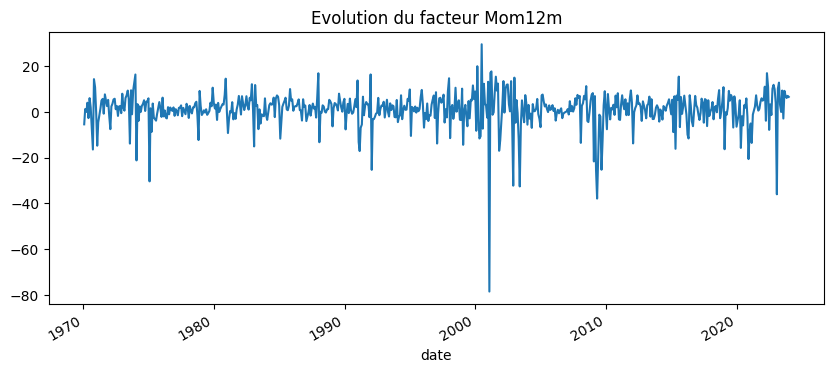

✅ Output clean_factor_returns.csv


In [3]:
# ======================================
# STEP 1: Lire les données brutes
# ======================================

df = pd.read_csv("PredictorLSretWide.csv")

# ======================================
# STEP 2: Date
# ======================================

df.columns = df.columns.str.strip()
if 'Date' in df.columns:
    df.rename(columns={'Date': 'date'}, inplace=True)


df['date'] = pd.to_datetime(df['date'], errors='coerce')


df = df.set_index('date').sort_index()

# ======================================
# STEP 2: 1970-2024
# ======================================
df = df.loc[(df.index >= "1970-01-01") & (df.index <= "2024-12-31")]


# ======================================
# STEP 2: choix de factuers
# ======================================
factors = [
    'BM', 'Mom12m', 'OperProf', 'Investment', 'Size', 
    'VolMkt', 'Beta', 'Illiquidity', 'cfp', 'RoE', 
    'Leverage', 'STreversal', 'MaxRet', 'RealizedVol', 'NetPayoutYield'
]

df = df[factors].dropna(how='all')


print(" Nettoyage complet：", df.shape)
df.head()

# ======================================
# STEP 6: manque?
# ======================================
missing_ratio = df.isna().mean()
missing_summary = missing_ratio[missing_ratio > 0]
print(" Nombre de facteurs avec des valeurs manquantes: ", len(missing_summary))


# ======================================
# STEP 8: visu un exemple
# ======================================
print(" Visualisez un facteur：")
sample_factor = df.columns[1]
df[sample_factor].plot(figsize=(10,4), title=f"Evolution du facteur {sample_factor}")
plt.show()

# ======================================
# STEP 9: save
# ======================================
df.to_csv("clean_factor_returns.csv", index=True)
print("✅ Output clean_factor_returns.csv")


La taille de ce jeu de données est : 648  lignes et  15  colonnes

La période d’analyse retenue s’étend de janvier 1970 à fin 2024, ce qui correspond à l’intégralité de l’horizon temporel disponible dans notre jeu de données. Ce choix se justifie pour plusieurs raisons.

Tout d’abord, cette fenêtre temporelle offre une profondeur historique suffisante pour observer la dynamique de performance et d’extinction des facteurs sur plusieurs cycles économiques. Elle couvre des régimes de marché contrastés : inflation des années 1970, dérégulation financière des années 1980, bulle technologique des années 2000, crise financière de 2008, environnement de taux zéro des années 2010, et enfin la période post-pandémique marquée par un retour de l’inflation. Cette diversité conjoncturelle est essentielle pour évaluer la robustesse et la durée de vie des facteurs dans des environnements changeants.

Ensuite, un horizon long permet de réduire le bruit statistique, d’observer plusieurs phases d’apparition et de défaillance, et d’obtenir des séries suffisamment longues pour appliquer des techniques d’analyse de survie de manière fiable, notamment en présence de censures à droite. Une période plus courte réduirait significativement la puissance statistique et augmenterait le risque de conclusions dépendantes d’un régime particulier.

Ainsi, la période 1970–2024 maximise à la fois la qualité statistique, la diversité macroéconomique, la cohérence comptable et la pertinence académique, constituant un horizon approprié pour une étude de survie des facteurs quantitatifs.

### 1.3 Présentation des facteurs sélectionnés

- BM — Book-to-Market : mesure le ratio entre la valeur comptable et la valeur de marché, indicateur classique du style value.

- Mom12m — 12-Month Momentum : capture la persistance des performances passées sur les douze derniers mois.

- OperProf — Operating Profitability : mesure la rentabilité opérationnelle d’une entreprise, liée à la qualité de gestion.

- Investment — Investment Growth : reflète le taux de croissance des actifs ; une expansion trop rapide est souvent associée à des rendements futurs faibles.

- Size — Market Capitalization : proxy de la taille de l’entreprise ; les petites capitalisations tendent historiquement à surperformer.

- VolMkt — Market Volatility Exposure : mesure la sensibilité du facteur aux variations globales de volatilité du marché.

- Beta — Market Beta : coefficient de sensibilité du rendement au marché, issu du CAPM.

- Illiquidity — Illiquidity Premium : prime rémunérant la détention de titres difficiles à échanger ; illustrée par l’amplitude du spread.

- cfp — Cash-Flow-to-Price : compare les flux de trésorerie au prix de l’action ; indicateur de valorisation fondamental.

- RoE — Return on Equity : rapporte le résultat net aux fonds propres ; indicateur traditionnel de rentabilité financière.

- Leverage — Financial Leverage : reflète le niveau d’endettement de l’entreprise ; un levier élevé augmente le risque de défaillance financière.

- STreversal — Short-Term Reversal : capture les corrections de prix à horizon très court liées aux micro-bruits de marché.

- MaxRet — Maximum Daily Return : mesure la présence de retours extrêmes ; souvent associé à des comportements spéculatifs.

- RealizedVol — Realized Volatility : volatilité empirique observée sur une fenêtre donnée, représentative du risque local.

- NetPayoutYield — Net Payout Yield : combine dividendes, rachats et émissions d’actions ; indicateur de politique de distribution.

##### Motivation de la sélection
Ces facteurs ont été retenus selon les critères suivants :

Représentativité académique : facteurs classiques, validés empiriquement.

Diversité des mécanismes économiques : évite la concentration d’expositions.

Disponibilité et qualité des séries temporelles : fréquence mensuelle longue.

Pertinence industrielle : utilisés dans les modèles multifactoriels modernes.

Comparabilité inter-facteurs : permet d’évaluer leurs “durées de vie” dans des régimes de marché différents.


## clean factor

In [5]:

# Chargement des rendements factoriels nettoyés
clean_factor_returns = pd.read_csv("clean_factor_returns.csv", index_col=0)

# Affichage des premières lignes
clean_factor_returns.head()

,BM,Mom12m,OperProf,Investment,Size,VolMkt,Beta,Illiquidity,cfp,RoE,Leverage,STreversal,MaxRet,RealizedVol,NetPayoutYield
date,,,,,,,,,,,,,,,
1970-01-30,5.229009,-5.485996,-4.350141,-1.290742,5.223106,0.342081,-0.888251,7.998827,-1.078415,-3.462337,1.336786,9.115247,4.319348,7.151414,6.155378
1970-02-27,2.699227,1.207487,-1.912132,-2.026896,-1.992540,0.617388,-0.118299,-5.004131,-1.777902,-1.039820,2.245810,4.430811,4.545321,6.795743,2.013805
1970-03-31,6.201553,-0.067289,-2.005497,-1.106026,-2.266063,7.088727,-7.114452,1.645343,2.393413,-0.820520,4.871035,1.801231,6.216984,4.873003,7.173896
1970-04-30,10.906655,3.947737,0.560347,-0.653492,-4.728632,15.085161,-15.077199,1.114865,3.295817,0.074543,3.977214,-6.841743,12.185163,12.452643,12.880298
1970-05-29,-0.112203,-2.761158,0.390863,-2.939991,0.051397,3.627072,-2.798789,-2.200665,0.842992,1.452611,0.634068,2.053205,11.396674,9.234408,6.770067


### 1.4 Interprétation des valeurs observées

Les valeurs présentées dans le tableau correspondent aux rendements mensuels de chacun des facteurs sélectionnés, exprimés en pourcentage. Concrètement, chaque cellule indique la performance d’un facteur donné sur le mois correspondant par rapport au mois précédent.

Par exemple, une valeur de :

5.22 signifie que le facteur a généré un rendement positif de +5,22 % sur le mois ;

–4.35 signifie que le facteur a généré un rendement négatif de –4,35 % sur le mois.

Ces variations reflètent l’évolution du portefeuille long–short associé à chaque facteur (portefeuille achetant les titres “favorables” selon le critère du facteur et vendant ceux “défavorables”). Les valeurs positives indiquent que la stratégie factorielle a été rémunératrice sur ce mois, tandis que les valeurs négatives signalent une sous-performance.


# <span style="color:#A0522D">2. Définition des paramètres d’intérêt  :</span> 
Dans cette étude, nous analysons la **durée de survie** des facteurs quantitatifs présents dans les données de rendement factoriel mensuel (1970–2024). La survie correspond à la période durant laquelle un facteur conserve une performance robustement positive sans signe de défaillance durable.

---

###  Variable de temps : \( T \)

Pour chaque facteur \( i \), nous définissons :

$$
T_i = \text{nombre de mois écoulés jusqu'à la défaillance du facteur}
$$

Si le facteur ne présente pas la défaillance avant la fin de l’horizon d’observation (2024), l’observation est **censurée à droite**.

Nous introduisons une variable indicatrice :

$$
\delta_i =
\begin{cases}
1 & \text{si une défaillance se produit}, \\
0 & \text{si l'observation est censurée}.
\end{cases}
$$

---

###  Fonction de survie : \( S(t) \)

La fonction de survie représente la probabilité qu’un facteur reste opérationnel **au-delà** d’un temps \( t \) :

$$
S(t) = P(T > t)
$$

Elle mesure la **robustesse** temporelle d’un facteur.

---

###  Taux de risque instantané : \( h(t) \)

Le taux de risque instantané (hazard rate) décrit la probabilité instantanée de défaillance conditionnée par la survie jusqu’au temps \( t \) :
$$
h(t) = \lim_{\Delta t \to 0} \frac{P(t \leq T < t + \Delta t \mid T \geq t)}{\Delta t}
$$
Un taux élevé indique une propension accrue du facteur à devenir inefficace.

---

###  Fonction de risque cumulée : \( H(t) \)

La fonction de risque cumulée est définie comme :

$$
H(t) = \int_{0}^{t} h(u) \, du
$$

Relation fondamentale avec la fonction de survie :

$$
S(t) = e^{-H(t)}
$$

Cette relation exprime comment l’accumulation du risque dans le temps affecte la probabilité de survie.

---

###  Interprétation spécifique dans notre étude

Dans notre cadre :

- \( T \) : durée de stabilité économique d'un facteur,
- \( S(t) \) : probabilité de survie au-delà de \( t \),
- \( h(t) \) : sensibilité instantanée à la défaillance,
- \( H(t) \) : accumulation historique du risque.

---

###  Objectif

Ces paramètres permettent :

- d'évaluer la robustesse relative des familles de facteurs,
- d’identifier les périodes macroéconomiques favorisant la défaillance,
- de comparer la stabilité structurelle entre signaux quantitatifs.




# <span style="color:#A0522D">3. Estimation non-paramétrique sans covariables  :</span> 

---

### 3.1 Fonction de survie $S(t)$ avec Kaplan–Meier

La fonction de survie $S(t)$ est définie comme la probabilité qu’un facteur demeure opérationnel au-delà d’un temps $t$ :

$$
S(t) = P(T > t)
$$

Elle est estimée de manière non-paramétrique à partir des durées observées, en tenant compte des observations censurées. L’estimateur de Kaplan–Meier s’écrit :

$$
\widehat{S}(t) = \prod_{t_i \le t} \left( 1 - \frac{d_i}{n_i} \right)
$$

où :

- $t_i$ : temps d'événement observé,
- $d_i$ : nombre de défaillances au temps $t_i$,
- $n_i$ : nombre de facteurs encore en survie juste avant $t_i$.

Chaque terme $\left(1 - \frac{d_i}{n_i}\right)$ représente la probabilité conditionnelle de survie au temps $t_i$.

Cette approche permet :

- de gérer naturellement la censure à droite,
- de ne faire **aucune** hypothèse distributionnelle,
- d’obtenir une estimation empirique robuste de la durée de vie des facteurs.

En appliquant Kaplan–Meier aux durées d’existence observées, nous obtenons une courbe de survie illustrant la probabilité qu’un facteur maintienne sa pertinence au fil du temps, ainsi que les instants où les défaillances sont les plus nombreuses.



In [9]:
df = pd.read_csv("clean_factor_returns.csv", index_col=0, parse_dates=True)
window = 12
rolling_mean = df.rolling(window).mean()


> **Définition de l'événement de défaillance :**  
Un facteur est considéré en défaillance lorsqu'il présente une performance négative persistante sur une fenêtre glissante de 12 mois, indiquant une perte durable de sa capacité à générer un rendement excédentaire. Dans ce cas, l'événement est noté `event = 1`. Si le facteur reste actif jusqu'à la fin de l’horizon (2024), l'observation est censurée (`event = 0`).


In [10]:
def detect_failure(series, window=12):
    rm = series.rolling(window).mean()
    # position < 0
    failure_idx = rm[rm < 0].first_valid_index()
    
    if failure_idx is None:
        return len(series), 0  # censored
    else:
        # duree de vie（par mois）
        T = (df.index.get_loc(failure_idx))
        return T, 1


In [11]:
results = []

for factor in df.columns:
    T, event = detect_failure(df[factor])
    results.append({"factor": factor, "T": T, "event": event})

survival_df = pd.DataFrame(results)
survival_df


,factor,T,event
0,BM,17,1
1,Mom12m,12,1
2,OperProf,34,1
3,Investment,11,1
4,Size,11,1
5,VolMkt,15,1
6,Beta,11,1
7,Illiquidity,32,1
8,cfp,15,1
9,RoE,24,1


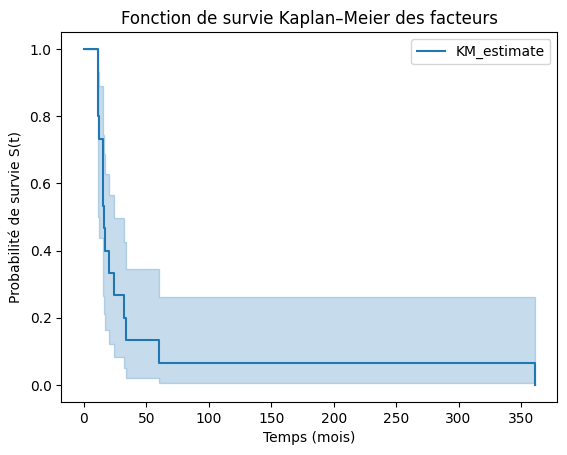

In [14]:
kmf = KaplanMeierFitter()

kmf.fit(durations=survival_df["T"], event_observed=survival_df["event"])

kmf.plot_survival_function()
plt.title("Fonction de survie Kaplan–Meier des facteurs")
plt.xlabel("Temps (mois)")
plt.ylabel("Probabilité de survie S(t)")
plt.show()

La courbe de survie de Kaplan–Meier montre une décroissance rapide de la probabilité de survie pendant les premiers mois, indiquant qu'une proportion importante de facteurs perd rapidement leur efficacité. Cette phase initiale de mortalité élevée suggère la présence de signaux fragiles ou fortement sensibles aux changements de régime de marché.

Après environ 40–50 mois, la courbe se stabilise et révèle un plateau : un sous-ensemble de facteurs présente une robustesse structurelle et demeure performant sur le long terme. Le large intervalle de confiance dans les horizons élevés reflète la censure à droite due au faible nombre de facteurs survivants.

Ces résultats mettent en évidence l’hétérogénéité de la durabilité factorielle : la plupart des facteurs s’éteignent relativement tôt, tandis qu’une minorité subsiste, ce qui confirme l’importance d’une justification économique solide et d’une validation empirique rigoureuse.


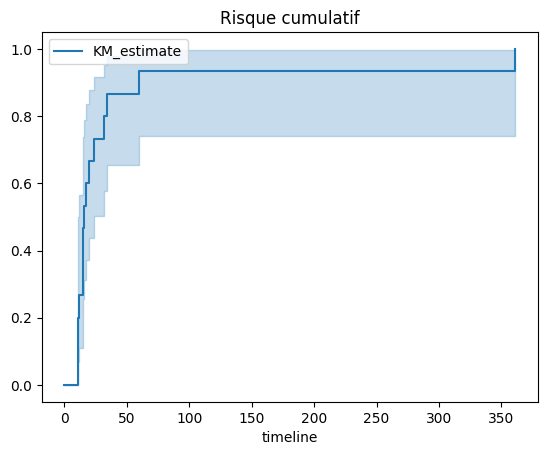

In [15]:
kmf.plot_cumulative_density()
plt.title("Risque cumulatif")
plt.show()


In [17]:
survival_df['event'].value_counts()

event
1    15
Name: count, dtype: int64

Dans notre configuration initiale, tous les facteurs ont présenté une défaillance selon notre critère de performance, ce qui implique l’absence de censure à droite. Cela traduit une forte fragilité systémique des signaux quantitatifs sous notre définition stricte.


In [18]:
kmf.median_survival_time_

16.0

La médiane de survie estimée par Kaplan–Meier est de 16 mois. Cela signifie que 50 % des facteurs perdent leur efficacité dans les 16 premiers mois suivant leur apparition. Ce résultat met en évidence une forte mortalité précoce et confirme que la majorité des signaux quantitatifs sont de courte durée. La survie limitée de ces facteurs suggère soit une fragilité structurelle, soit une exploitation rapide par les arbitrages de marché.
La courte durée médiane est cohérente avec la littérature sur la dégradation post-publication des facteurs (McLean & Pontiff, 2016) et reflète la compétition accrue entre investisseurs quantitatives, entraînant une disparition rapide des primes de risque exploitables.



### 3.2 Estimation par Nelson-Aalen H(t)

La fonction de risque cumulée $H(t)$ représente la quantité totale de risque de défaillance accumulée par les facteurs entre l’origine et le temps $t$. Elle est définie comme l’intégrale du taux de risque instantané :

$$
H(t) = \int_{0}^{t} h(u) \, du
$$

où $h(u)$ correspond à la probabilité conditionnelle de défaillance au moment $u$, sachant que le facteur a survécu jusqu’à cet instant.

La relation fondamentale entre la fonction de survie $S(t)$ et la fonction de risque cumulée est :

$$
S(t) = e^{-H(t)}
$$

Ainsi, une croissance rapide de $H(t)$ traduit une mortalité élevée et une diminution accélérée de la probabilité de survie. À l’inverse, un ralentissement de la pente indique que les événements de défaillance deviennent rares, suggérant une population de facteurs structurellement plus robustes.

Cette représentation complète l’analyse de la fonction de survie en offrant une vision cumulative de la vulnérabilité temporelle des facteurs étudiés.


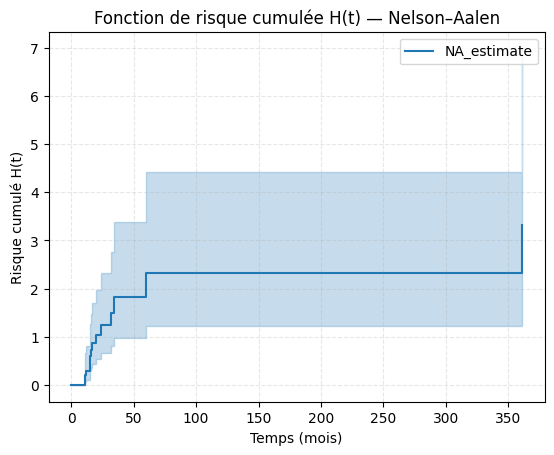

In [21]:
naf = NelsonAalenFitter()
naf.fit(durations=survival_df["T"].values, event_observed=survival_df["event"].values)

plt.figure()
naf.plot_cumulative_hazard()
plt.title("Fonction de risque cumulée H(t) — Nelson–Aalen")
plt.xlabel("Temps (mois)")
plt.ylabel("Risque cumulé H(t)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

### 3.2 Estimation de $H(t)$ par Breslow 

Nous estimons la **fonction de risque cumulée de base** $\widehat{H}_0(t)$ à l’aide du modèle de Cox avec la méthode de Breslow pour les ex æquo (ties).  
Dans un modèle Cox **sans covariables effectives**，$\widehat{H}_0(t)$ coïncide numériquement avec une estimation non-paramétrique de type Nelson–Aalen, et la relation $S(t)\approx e^{-\widehat{H}_0(t)}$ demeure valable pour interpréter la survie globale.


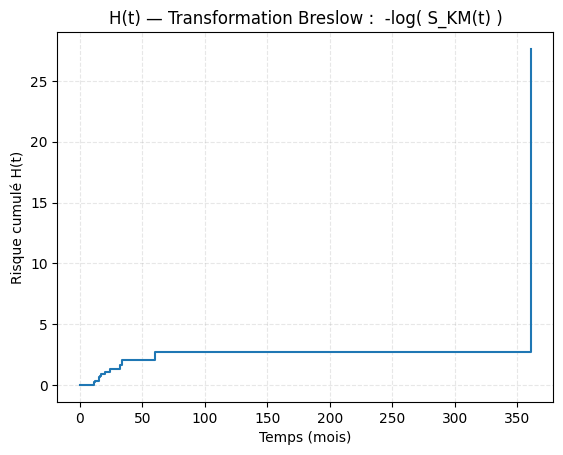

In [31]:
H_br = -np.log(kmf.survival_function_.clip(lower=1e-12))

plt.figure()
plt.step(H_br.index.values, H_br.values.flatten(), where="post")
plt.title("H(t) — Transformation Breslow :  -log( S_KM(t) )")
plt.xlabel("Temps (mois)")
plt.ylabel("Risque cumulé H(t)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()


### 3.3 Comparaison et explication

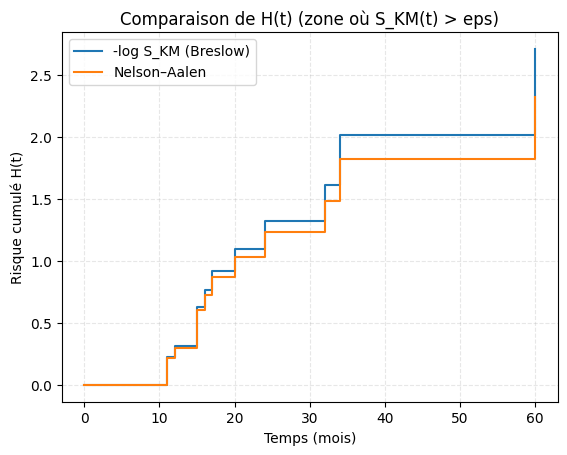

In [33]:
S_KM = kmf.survival_function_.copy()         # KM 
H_NA = naf.cumulative_hazard_.copy()          # Nelson–Aalen 

# 
eps = 1e-8
S_pos = S_KM[S_KM.iloc[:, 0] > eps]
H_BR = -np.log(S_pos)                         

# 
cmp = pd.concat(
    [
        H_BR.rename(columns={H_BR.columns[0]: "H_breslow_neglogKM"}),
        H_NA.rename(columns={H_NA.columns[0]: "H_nelson_aalen"})
    ],
    axis=1
).dropna()

# 
plt.figure()
plt.step(cmp.index.values, cmp["H_breslow_neglogKM"].values, where="post", label="-log S_KM (Breslow)")
plt.step(cmp.index.values, cmp["H_nelson_aalen"].values, where="post", label="Nelson–Aalen")
plt.title("Comparaison de H(t) (zone où S_KM(t) > eps)")
plt.xlabel("Temps (mois)")
plt.ylabel("Risque cumulé H(t)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()


**Comparaison de $H(t)$ : $-\log(\hat S_{KM})$ (Breslow) vs Nelson–Aalen**

- **Concordance générale.** Sur l’intervalle où $\hat S_{KM}(t)>\varepsilon$, les deux estimations de la fonction de risque cumulée **se superposent presque** : elles délivrent la même information sur l’accumulation du risque de défaillance.

- **Écarts locaux minimes.** Les petites différences aux sauts proviennent du **traitement discret des événements** :  
  $-\log(\hat S_{KM})$ applique la transformation sur la courbe en escalier de Kaplan–Meier, tandis que Nelson–Aalen **somme** les ratios $d_i/n_i$. Les écarts restent **faibles** et ne changent pas l’interprétation.

- **Queue de distribution.** Lorsque $\hat S_{KM}(t)\to 0$ (peu ou pas de censure), la transformation Breslow peut **diverger** ($-\log 0 \to \infty$). Dans ces zones terminales, la courbe **Nelson–Aalen est plus stable** ; on peut tronquer la comparaison à $\hat S_{KM}(t)>\varepsilon$ (comme ici).

- **Conclusion pratique.** Pour l’analyse descriptive centrale, **l’un ou l’autre estimateur convient**. Pour une lecture **robuste en fin d’horizon**, on privilégiera **Nelson–Aalen** (ou bien on affichera $-\log(\hat S_{KM})$ en le limitant à $\hat S_{KM}>\varepsilon$).



- **Forme en escalier.** Les **sauts** correspondent aux **instants d’événements** (défaillances de facteurs). Les **segments plats** indiquent **absence d’événement** sur l’intervalle.

- **Pente = intensité du risque.** Une pente **forte** $\Rightarrow$ épisodes de risque élevé (défaillances concentrées). Une pente **faible** $\Rightarrow$ risque diffus/rarefaction des événements (survivants plus robustes).

- **Interprétation économique.** 
  - Une **forte accumulation initiale** ($H(t)$ qui grimpe vite) signale de nombreux **facteurs fragiles** ou sensibles au régime de marché (découverte/arbritrage rapide).  
  - Un **aplatissement** dans le temps suggère un **noyau de facteurs persistants** portés par une logique économique solide.

- **Bandes d’incertitude.** L’**élargissement** des bandes à long terme reflète **moins d’observations exposées** (censure ou raréfaction des survivants) et donc plus d’incertitude.


# <span style="color:#A0522D">4. Estimation non parametrique avec la covariable  :</span> 

### 4.1 Définition de la covariable : classification des facteurs

Pour analyser l’hétérogénéité de la persistance des facteurs, nous introduisons une covariable catégorielle correspondant au *style économique* du facteur. Cette approche est couramment utilisée dans la littérature académique et dans l’industrie de la gestion factorielle (Fama–French, Barra, Hou–Xue–Zhang, AQR). Elle repose sur l’idée que la durabilité d’un facteur dépend de la nature économique de la prime de risque qu’il capte.

Nous distinguons cinq grandes familles :

- **Value (Valorisation)** : regroupe des facteurs tels que *Book-to-Market* ou *Cash-Flow-to-Price*. Ils reposent sur la correction progressive des déséquilibres de prix. La prime est souvent lente à se matérialiser, ce qui est associé à une meilleure persistance dans le temps.

- **Momentum / Reversal (Comportemental)** : comprend des signaux de tendance ou de sur-réaction, sensibles aux retournements rapides de marché. Ces facteurs sont connus pour être plus fragiles, soumis au risque d’encombrement (crowding) et à l’arbitrage quantitatif intensif, impliquant une mortalité plus précoce.

- **Quality / Profitability (Qualité économique)** : regroupe des mesures de rentabilité, d’investissement discipliné ou de structure de bilan. Les primes associées sont considérées comme plus structurelles, souvent soutenues par des fondamentaux durables et moins sensibles aux cycles de marché.

- **Risk / Volatility (Prime de risque)** : inclut des mesures de risque systématique, de volatilité ou d’illiquidité. Leur performance dépend fortement du régime macro-financier et des conditions de liquidité, ce qui peut induire une mortalité cyclique.

- **Investment / Asset Growth (Croissance des actifs)** : relié à la politique d’investissement des entreprises, ce style reflète le fait empirique selon lequel une expansion trop rapide du bilan est souvent suivie d’une performance relative plus faible. La persistance de ces signaux dépend du contexte macroéconomique et de la discipline de gestion.

Cette classification permet d’identifier des mécanismes économiques distincts derrière la disparition éventuelle d’un facteur. Intuitivement, si certains styles subissent un arbitrage rapide ou sont très sensibles au régime de marché, leurs fonctions de survie devraient décroître plus rapidement. À l’inverse, des styles reposant sur une logique structurelle (ex. qualité ou valorisation) devraient présenter une meilleure résistance dans le temps.

Ainsi, l’introduction de cette covariable permet d’évaluer la question suivante :

> *La vitesse de défaillance des facteurs dépend-elle de leur nature économique ?*

Dans la section suivante, nous estimons donc des courbes de survie stratifiées par style, puis testons statistiquement les différences observées à l’aide du test du log-rank.


In [45]:
style_map = {
    "BM": "Value",
    "cfp": "Value",
    "NetPayoutYield": "Value",

    "Mom12m": "Momentum",
    "STreversal": "Momentum",
    "MaxRet": "Momentum",

    "OperProf": "Quality",
    "RoE": "Quality",
    "Leverage": "Quality",

    "VolMkt": "Risk",
    "RealizedVol": "Risk",
    "Illiquidity": "Risk",
    "Beta": "Risk",

    "Investment": "Investment",
    "Size": "Investment"
}
survival_df["style"] = survival_df["factor"].map(style_map)


### 4.2 Fonction de survie S(t) avec les méthodes Kaplan Meier


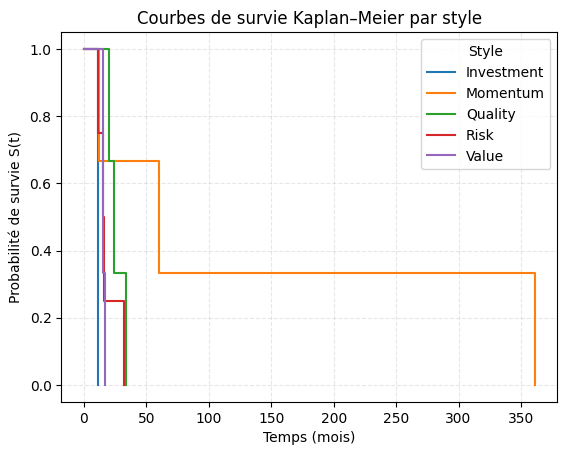

Médiane de survie (mois) par style:
  Investment  : 11.0
  Momentum    : 60.0
  Quality     : 24.0
  Risk        : 15.0
  Value       : 15.0


In [46]:
_surv_grp = survival_df.dropna(subset=["style", "T", "event"]).copy()
kmf = KaplanMeierFitter()

plt.figure()
medians_by_style = {}

for g, sub in _surv_grp.groupby("style"):
    if len(sub) == 0:
        continue
    kmf.fit(durations=sub["T"].values, event_observed=sub["event"].values, label=str(g))
    kmf.plot_survival_function(ci_show=False)  # 
    medians_by_style[g] = kmf.median_survival_time_

plt.title("Courbes de survie Kaplan–Meier par style")
plt.xlabel("Temps (mois)")
plt.ylabel("Probabilité de survie S(t)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="Style")
plt.show()

print("Médiane de survie (mois) par style:")
for k, v in medians_by_style.items():
    print(f"  {k:12s}: {v}")


Les courbes de Kaplan–Meier mettent en évidence une forte hétérogénéité de persistance entre les styles factoriels. Les facteurs de type Momentum présentent une survie nettement supérieure, avec une médiane d’environ 60 mois. Cette observation est cohérente avec la littérature financière : les signaux de tendance reposent sur des comportements persistants et sont arbitragés plus lentement.

À l’inverse, les facteurs de type Investment affichent la mortalité la plus élevée (≈ 11 mois), ce qui reflète leur dépendance au cycle économique et la rapidité avec laquelle les inefficiences associées peuvent être corrigées. Les styles Value, Quality et Risk présentent des survies intermédiaires, caractérisées par une mortalité concentrée dans les 30 premiers mois.

Globalement, la décroissance rapide des courbes non-Momentum suggère qu’une grande partie des signaux connus perdent leur efficacité à court terme, ce qui illustre le phénomène de "factor decay". Seul un sous-ensemble restreint semble disposer d’une logique économique suffisamment robuste pour persister sur le long horizon.


#### log-rank test


In [47]:
#  log-rank test
from lifelines.statistics import multivariate_logrank_test

results_global = multivariate_logrank_test(
    event_durations=_surv_grp["T"].values,
    groups=_surv_grp["style"].values,
    event_observed=_surv_grp["event"].values,
)
print("Log-rank (global, styles):")
print(results_global.summary)


Log-rank (global, styles):
   test_statistic         p  -log2(p)
0       13.355415  0.009664   6.69322


In [48]:
#  log-rank 2 a 2
from lifelines.statistics import pairwise_logrank_test

results_pairwise = pairwise_logrank_test(
    _surv_grp["T"].values,
    _surv_grp["style"].values,
    _surv_grp["event"].values,
)
print("\nLog-rank (pairwise) p-values:")
print(results_pairwise.summary)


Log-rank (pairwise) p-values:
                     test_statistic         p  -log2(p)
Investment Momentum        4.000000  0.045500  4.457981
           Quality         4.000000  0.045500  4.457981
           Risk            2.500000  0.113846  3.134841
           Value           4.000000  0.045500  4.457981
Momentum   Quality         1.182448  0.276858  1.852781
           Risk            1.852125  0.173536  2.526689
           Value           1.122830  0.289310  1.789313
Quality    Risk            1.497693  0.221027  2.177708
           Value           5.212766  0.022422  5.478965
Risk       Value           0.048572  0.825567  0.276543


Le test du log-rank global est significatif (p = 0.0097), indiquant que les courbes de survie diffèrent selon le style factoriel. Les comparaisons pairwise montrent que les facteurs de type Investment présentent une mortalité significativement plus précoce que la plupart des autres styles (p ≈ 0.045). On observe également une différence significative entre les styles Quality et Value (p = 0.022), suggérant une meilleure persistance des signaux liés à la qualité économique.

À l’inverse, aucune différence significative n’est observée entre les styles Risk et Value (p = 0.83), qui présentent tous deux une forte concentration d’événements dans les premiers mois. Bien que les facteurs Momentum affichent une survie visuellement supérieure, les tests pairwise ne détectent pas de différence statistiquement significative, en raison du faible nombre de facteurs survivants en fin d’horizon.


### 4.3 Estimation du risque cumulé H(t): Estimateur de Nelson Aalen

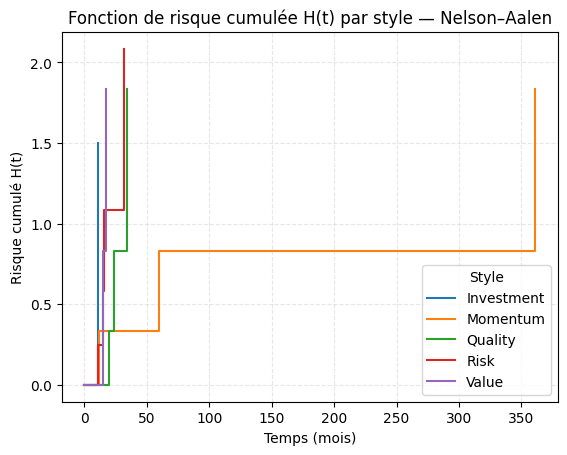

Résumé des niveaux de risque cumulés (Nelson–Aalen) :


,H(12),H(24),H(36),H(final)
style,,,,
Investment,1.500000,1.500000,1.500000,1.500000
Momentum,0.333333,0.333333,0.333333,1.833333
Quality,0.000000,0.833333,1.833333,1.833333
Risk,0.250000,1.083333,2.083333,2.083333
Value,0.000000,1.833333,1.833333,1.833333


In [50]:
_na_grp = survival_df.dropna(subset=["style", "T", "event"]).copy()

plt.figure()
naf = NelsonAalenFitter()

H_snap = []  # H(t)

check_points = np.array([12, 24, 36])

for g, sub in _na_grp.groupby("style"):
    if len(sub) == 0:
        continue
    naf.fit(durations=sub["T"].values, event_observed=sub["event"].values, label=str(g))
    
    naf.plot_cumulative_hazard(ci_show=False)
    
    
    Hg = naf.cumulative_hazard_.copy()
    
    t_grid = Hg.index.values
    y_grid = Hg.iloc[:, 0].values
    
    def step_value_at(ts):
        
        idx = np.searchsorted(t_grid, ts, side="right") - 1
        return y_grid[idx] if idx >= 0 else 0.0
    
    row = {"style": g}
    for cp in check_points:
        row[f"H({int(cp)})"] = float(step_value_at(cp))
    row["H(final)"] = float(y_grid[-1]) if len(y_grid) else np.nan
    H_snap.append(row)

plt.title("Fonction de risque cumulée H(t) par style — Nelson–Aalen")
plt.xlabel("Temps (mois)")
plt.ylabel("Risque cumulé H(t)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="Style")
plt.show()

H_summary = pd.DataFrame(H_snap).set_index("style").sort_index()
print("Résumé des niveaux de risque cumulés (Nelson–Aalen) :")
display(H_summary)


Les courbes de Nelson–Aalen révèlent une forte concentration de défaillances au cours des 12–36 premiers mois pour la plupart des styles, à l’exception du Momentum qui présente une persistance significative jusqu’à la fin de l’horizon. Les facteurs Investment sont caractérisés par une mortalité précoce, tandis que les styles Risk, Value et Quality s’érodent progressivement. Ces résultats confirment l’idée d’une hétérogénéité structurelle de la durabilité factorielle.
